In [1]:
%matplotlib inline


# Epilepsy Detection Using EEG Data


In this example we'll use the |cesium|_ library to compare
various techniques for epilepsy detection using a classic EEG time series dataset from
`Andrzejak et al.  <http://www.meb.uni-bonn.de/epileptologie/science/physik/eegdata.html>`_.
The raw data are separated into five classes: Z, O, N, F, and S; we will consider a
three-class classification problem of distinguishing normal (Z, O), interictal (N, F), and
ictal (S) signals.

The overall workflow consists of three steps: first, we "featurize" the time series by
selecting some set of mathematical functions to apply to each; next, we build some
classification models which use these features to distinguish between classes;
finally, we validate our models by generating predictions for some unseen
holdout set and comparing them to the true class labels.

First, we'll load the data and inspect a representative time series from each class:

.. |cesium| replace:: ``cesium``



Loaded data from cached archive.


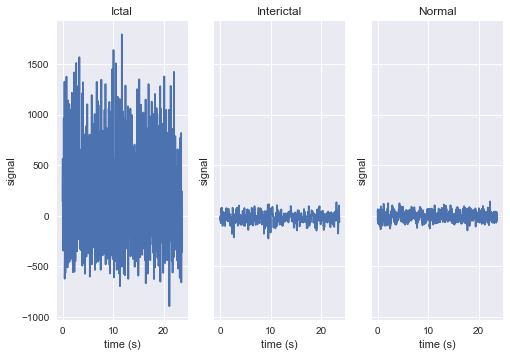

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

from cesium import datasets

eeg = datasets.fetch_andrzejak()

# Group together classes (Z, O), (N, F), (S) as normal, interictal, ictal
eeg["classes"] = eeg["classes"].astype("U16") #  allocate memory for longer class names
eeg["classes"][np.logical_or(eeg["classes"]=="Z", eeg["classes"]=="O")] = "Normal"
eeg["classes"][np.logical_or(eeg["classes"]=="N", eeg["classes"]=="F")] = "Interictal"
eeg["classes"][eeg["classes"]=="S"] = "Ictal"

fig, ax = plt.subplots(1, len(np.unique(eeg["classes"])), sharey=True)
for label, subplot in zip(np.unique(eeg["classes"]), ax):
    i = np.where(eeg["classes"] == label)[0][0]
    subplot.plot(eeg["times"][i], eeg["measurements"][i])
    subplot.set(xlabel="time (s)", ylabel="signal", title=label)

Featurization
-------------
Once the data is loaded, we can generate features for each time series using the
|cesium.featurize|_ module. The ``featurize`` module includes many built-in
choices of features which can be applied for any type of time series data;
here we've chosen a few generic features that do not have any special
biological significance.

By default, the time series will featurized in parallel using the
``dask.multiprocessing`` scheduler; other approaches, including serial and
distributed approaches, can be implemented by passing in other ``dask``
schedulers as the ``get`` argument to ``featurize_time_series``.

.. |cesium.featurize| replace:: ``cesium.featurize``



In [3]:
from cesium import featurize
features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "maximum",
                   "max_slope",
                   "median",
                   "median_absolute_deviation",
                   "percent_close_to_median",
                   "minimum",
                   "skew",
                   "std",
                   "weighted_average"]
fset_cesium = featurize.featurize_time_series(times=eeg["times"],
                                              values=eeg["measurements"],
                                              errors=None,
                                              features_to_use=features_to_use)
print(fset_cesium.head())

feature amplitude percent_beyond_1_std maximum     max_slope median  \
channel         0                    0       0             0      0   
0           143.5             0.162558   141.0  11107.796610   -4.0   
1           211.5             0.145472   169.0  20653.559322  -51.0   
2           165.0             0.152307   184.0  13537.627119   13.0   
3           171.5             0.152307   162.0  17008.813559   -4.0   
4           170.0             0.152062   152.0  13016.949153  -18.0   

feature median_absolute_deviation percent_close_to_median minimum      skew  \
channel                         0                       0       0         0   
0                            28.0                0.505004  -146.0  0.032805   
1                            32.0                0.640469  -254.0 -0.092715   
2                            31.0                0.515987  -146.0 -0.004100   
3                            31.0                0.541128  -181.0  0.063678   
4                           

The output of ``featurize_time_series`` is a ``pandas.DataFrame`` which contains all
the feature information needed to train a machine learning model: feature
names are stored as column indices (as well as channel numbers, as we'll see
later for multi-channel data), and the time series index/class label are
stored as row indices.



Custom feature functions
~~~~~~~~~~~~~~~~~~~~~~~~
Custom feature functions not built into ``cesium`` may be passed in using the
``custom_functions`` keyword, either as a dictionary ``{feature_name: function}``, or as a
`dask graph <http://dask.pydata.org/en/latest/custom-graphs.html>`_. Functions should take
three arrays ``times, measurements, errors`` as inputs; details can be found in the
``cesium.featurize``
`documentation <http://cesium-ml.org/docs/api/cesium.featurize.html>`_.
Here we'll compute five standard features for EEG analysis provided by
`Guo et al. (2012) <http://linkinghub.elsevier.com/retrieve/pii/S0957417411003253)>`_:



In [4]:
import numpy as np
import scipy.stats

def mean_signal(t, m, e):
    return np.mean(m)

def std_signal(t, m, e):
    return np.std(m)

def mean_square_signal(t, m, e):
    return np.mean(m ** 2)

def abs_diffs_signal(t, m, e):
    return np.sum(np.abs(np.diff(m)))

def skew_signal(t, m, e):
    return scipy.stats.skew(m)

Now we'll pass the desired feature functions as a dictionary via the
``custom_functions`` keyword argument.



In [6]:
guo_features = {
    "mean": mean_signal,
    "std": std_signal,
    "mean2": mean_square_signal,
    "abs_diffs": abs_diffs_signal,
    "skew": skew_signal
}

fset_guo = featurize.featurize_time_series(times=eeg["times"], values=eeg["measurements"],
                                           errors=None,
                                           features_to_use=list(guo_features.keys()),
                                           custom_functions=guo_features)
print(fset_guo.head())

feature       mean        std        mean2 abs_diffs      skew
channel          0          0            0         0         0
0        -4.132048  40.411000  1650.122773   46948.0  0.032805
1       -52.444716  48.812668  5133.124725   61118.0 -0.092715
2        12.705150  47.144789  2384.051989   51269.0 -0.004100
3        -3.992433  47.072316  2231.742495   75014.0  0.063678
4       -17.999268  44.910958  2340.967781   52873.0  0.142753


Multi-channel time series
~~~~~~~~~~~~~~~~~~~~~~~~~
The EEG time series considered here consist of univariate signal measurements along a
uniform time grid. But ``featurize_time_series`` also accepts multi-channel
data; to demonstrate this, we will decompose each signal into five frequency
bands using a discrete wavelet transform as suggested by
`Subasi (2005) <http://www.sciencedirect.com/science/article/pii/S0957417404001745>`_,
and then featurize each band separately using the five functions from above.



In [9]:
import pywt

n_channels = 5
eeg["dwts"] = [pywt.wavedec(m, pywt.Wavelet("db1"), level=n_channels-1)
               for m in eeg["measurements"]]
fset_dwt = featurize.featurize_time_series(times=None, values=eeg["dwts"], errors=None,
                                           features_to_use=list(guo_features.keys()),
                                           custom_functions=guo_features)
print(fset_dwt.head())

feature        mean                                                 std  \
channel           0         1         2         3         4           0   
0        -17.080739 -6.067121 -0.979336  0.154634  0.035545  112.473774   
1       -210.210117 -3.743191  0.511377  0.057561 -0.024847  119.836067   
2         51.831712  0.714981  0.247418 -0.101951  0.007937  134.809626   
3        -15.429961  9.348249 -0.099243 -0.228293  0.181522  104.420503   
4        -71.982490 -3.787938 -0.183324 -0.034146 -0.048314  124.012203   

feature                                                ...    abs_diffs  \
channel          1          2          3          4    ...            0   
0        72.970862  48.167301  25.774846  10.154899    ...     25127.00   
1        92.777487  67.005780  33.957464  13.673398    ...     28742.00   
2        78.294247  60.275759  28.088980  11.246134    ...     28284.75   
3        89.999242  67.249397  35.929621  16.366747    ...     24848.25   
4        73.870175  59.9

The output featureset has the same form as before, except now the ``channel``
component of the column index is used to index the features by the
corresponding frequency band.



Model Building
--------------
Featuresets produced by ``cesium.featurize`` are compatible with the ``scikit-learn``
API. For this example, we'll test a random forest classifier for the
built-in ``cesium`` features, and a 3-nearest neighbors classifier for the
others, as suggested by
`Guo et al. (2012) <http://linkinghub.elsevier.com/retrieve/pii/S0957417411003253>`_.



In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

train, test = train_test_split(np.arange(len(eeg["classes"])), random_state=0)

model_cesium = RandomForestClassifier(n_estimators=128, max_features="auto",
                                      random_state=0)
model_cesium.fit(fset_cesium.iloc[train], eeg["classes"][train])

model_guo = KNeighborsClassifier(3)
model_guo.fit(fset_guo.iloc[train], eeg["classes"][train])

model_dwt = KNeighborsClassifier(3)
model_dwt.fit(fset_dwt.iloc[train], eeg["classes"][train])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

Prediction
----------
Making predictions for new time series based on these models follows the same
pattern: first the time series are featurized using ``featurize_time_series``,
and then predictions are made based on these features using the ``predict``
method of the ``scikit-learn`` model.



In [11]:
from sklearn.metrics import accuracy_score

preds_cesium = model_cesium.predict(fset_cesium)
preds_guo = model_guo.predict(fset_guo)
preds_dwt = model_dwt.predict(fset_dwt)

print("Built-in cesium features: training accuracy={:.2%}, test accuracy={:.2%}".format(
          accuracy_score(preds_cesium[train], eeg["classes"][train]),
          accuracy_score(preds_cesium[test], eeg["classes"][test])))
print("Guo et al. features: training accuracy={:.2%}, test accuracy={:.2%}".format(
          accuracy_score(preds_guo[train], eeg["classes"][train]),
          accuracy_score(preds_guo[test], eeg["classes"][test])))
print("Wavelet transform features: training accuracy={:.2%}, test accuracy={:.2%}".format(
          accuracy_score(preds_dwt[train], eeg["classes"][train]),
          accuracy_score(preds_dwt[test], eeg["classes"][test])))

Built-in cesium features: training accuracy=100.00%, test accuracy=83.20%
Guo et al. features: training accuracy=92.80%, test accuracy=83.20%
Wavelet transform features: training accuracy=97.87%, test accuracy=95.20%


The workflow presented here is intentionally simplistic and omits many important steps
such as feature selection, model parameter selection, etc., which may all be
incorporated just as they would for any other ``scikit-learn`` analysis.
But with essentially three function calls (``featurize_time_series``,
``model.fit``, and ``model.predict``), we are able to build a
model from a set of time series and make predictions on new, unlabeled data. In
upcoming posts we'll introduce the web frontend for ``cesium`` and describe how
the same analysis can be performed in a browser with no setup or coding required.

